In [1]:
%%writefile conf/config.yaml
defaults :
  - modulus_default
  - arch:
      - fully_connected
  - scheduler: tf_exponential_lr
  - optimizer: adam
  - loss: sum
  - _self_

save_filetypes : "vtk,npz"

scheduler:
  decay_rate: 0.95
  decay_steps: 100

training:
  rec_results_freq: 1000
  max_steps: 10000

batch_size:
  IC: 3000
  interior:  3000
    

Overwriting conf/config.yaml


In [2]:
%%writefile fhnModulus.py
from modulus.models.fully_connected import FullyConnectedArch

from sympy import Symbol, Eq
from sympy import Symbol, Function, Number
from modulus.eq.pde import PDE
import numpy as np
import matplotlib.pyplot as plt
from scipy import interpolate
import modulus
from modulus.hydra import instantiate_arch, ModulusConfig
from modulus.solver import Solver
from modulus.domain import Domain
from modulus.geometry.primitives_1d import Point1D
from modulus.domain.constraint import (
    PointwiseBoundaryConstraint,
    PointwiseBoundaryConstraint,
)
from modulus.domain.validator import PointwiseValidator
from modulus.key import Key
from modulus.node import Node
from modulus.eq.pde import PDE
from modulus.geometry import Parameterization
def generateExactSolution(t,dt,x0):
    
    n=int(t/dt)
    Sol=np.zeros(n)
    Sol[0]=x0
    T=0
    k=0
    while(k<n-1):
        x=Sol[k]
        Sol[k+1]=x*(x-0.2)*(1-x)*dt +  x
        T=T+dt
        k=k+1
    return Sol

class SpringMass(PDE):
    name = "SpringMass"

    def __init__(self):

      
     

        t = Symbol("t")
        input_variables = {"t": t}

        x1 = Function("x1")(*input_variables)



        self.equations = {}
        self.equations["ode_x1"] = x1*(1-x1)*(x1-0.2) -x1.diff(t)
        
@modulus.main(config_path="conf", config_name="config")
def run(cfg: ModulusConfig) -> None:
    u0=0.1
    # make list of nodes to unroll graph on
    sm = SpringMass()
    sm.pprint()
    sm_net = FullyConnectedArch(
        input_keys=[Key("t"), Key("K")],
        output_keys=[Key("x1")],
    )
    nodes = sm.make_nodes() + [
        sm_net.make_node(name="network")
    ]

   
    # add constraints to solver
    # make geometry
    geo = Point1D(0)
    t_max = 10.0
    t_symbol = Symbol("t")
    u_symbol = Symbol("x1")
    k_symbol= Symbol("K")
    time_range = {t_symbol: (0, t_max)}

    # make domain
    domain = Domain()

    # initial conditions
    IC = PointwiseBoundaryConstraint(
        nodes=nodes,
        geometry=geo,
        outvar={"x1": k_symbol},
        batch_size=cfg.batch_size.IC,
        lambda_weighting={
            "x1": 1.0,


        },
        parameterization={t_symbol: 0,**{k_symbol: (0.1, 1)}},
    )
    domain.add_constraint(IC, name="IC")

    
    
    # solve over given time period
    interior = PointwiseBoundaryConstraint(
        nodes=nodes,
        geometry=geo,
        outvar={"ode_x1": 0.0},
        batch_size=cfg.batch_size.interior,
        parameterization={**time_range,**{k_symbol: (0.1, 1)}},
    )
    domain.add_constraint(interior, "interior")
    
    # add validation data
  
 
    T=np.empty([0])
    K=np.empty([0])
    SOLs=np.empty([0])
    krange=[0.1,0.3,0.6,0.8]
    
    deltaT = 0.01
    
    
    for KR in krange:
        t = np.arange(0, t_max, deltaT)
        t = np.expand_dims(t, axis=-1)
        T=np.append(T,t)
        K = np.append(K,np.full_like (t,KR))
        SOLs=np.append(SOLs,np.array(generateExactSolution(t_max,deltaT,KR)))
        plt.plot(SOLs)
    
    
    
    
    
    
    
    
    t=np.expand_dims(T,axis=-1)
    k=np.expand_dims(K,axis=-1)
    sol=SOLs
    
    invar_numpy = {"t": t,"K":k}
    outvar_numpy = {
        "x1": sol
    }
    validator = PointwiseValidator(
        nodes=nodes, invar=invar_numpy, true_outvar=outvar_numpy, batch_size=1024
    )
    domain.add_validator(validator)

    # make solver
    slv = Solver(cfg, domain)

    # start solver
    slv.solve()


if __name__ == "__main__":
    run()


Overwriting fhnModulus.py


In [3]:
!rm -r outputs || true ##se não limpar o output ele aproveita o treinamento, mesmo se mudar o modelo
!python fhnModulus.py

[03:16:44] - JIT using the NVFuser TorchScript backend
[03:16:44] - JitManager: {'_enabled': True, '_arch_mode': <JitArchMode.ONLY_ACTIVATION: 1>, '_use_nvfuser': True, '_autograd_nodes': False}
[03:16:44] - GraphManager: {'_func_arch': False, '_debug': False, '_func_arch_allow_partial_hessian': True}
ode_x1: (1 - x1)*(x1 - 0.2)*x1 - x1__t
[03:16:47] - Installed PyTorch version 1.13.1+cu117 is not TorchScript supported in Modulus. Version 1.13.0a0+d321be6 is officially supported.
[03:16:47] - attempting to restore from: outputs/fhnModulus
[03:16:47] - optimizer checkpoint not found
[03:16:47] - model network.0.pth not found
[03:16:49] - [step:          0] record constraint batch time:  4.346e-01s
[03:16:49] - [step:          0] record validators time:  3.587e-01s
[03:16:49] - [step:          0] saved checkpoint to outputs/fhnModulus
[03:16:49] - [step:          0] loss:  3.962e-01
[03:16:51] - Attempting cuda graph building, this may take a bit...
[03:16:53] - [step:        100] loss: 

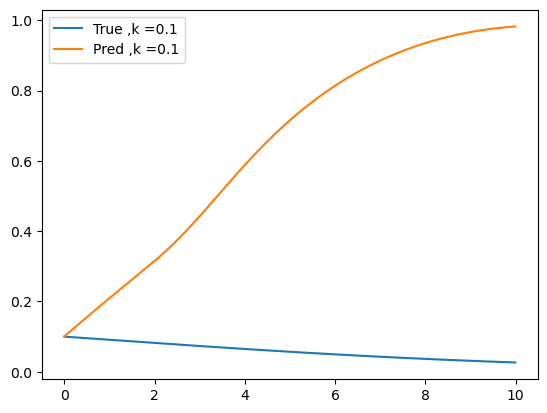

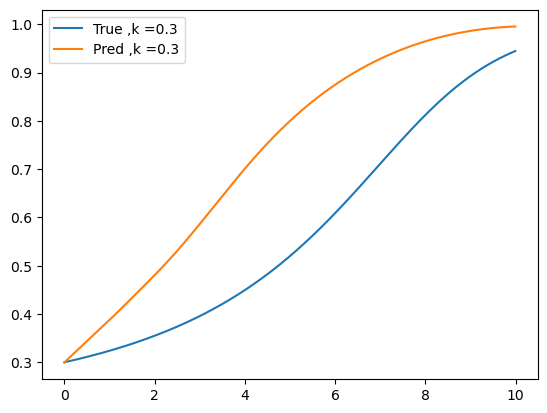

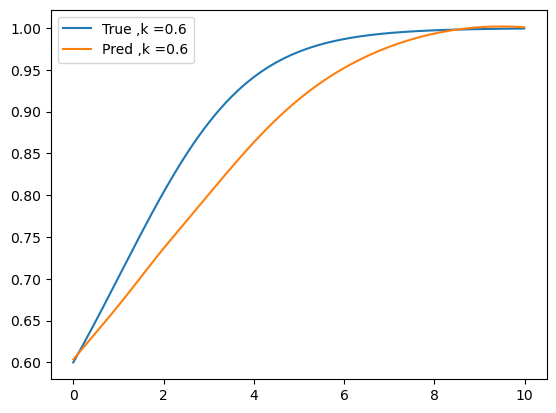

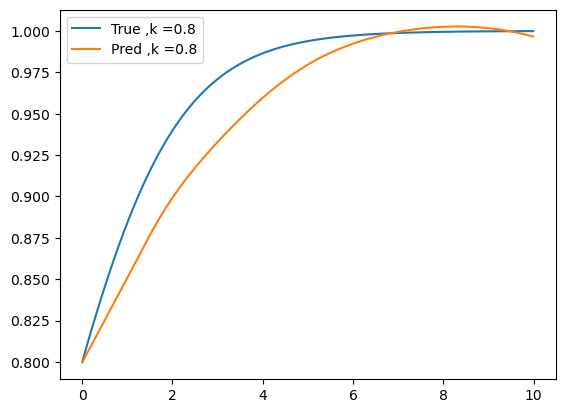

In [4]:
import numpy as np
import matplotlib.pyplot as plt

def find(list_to_check, item_to_find):
    return [idx for idx, value in enumerate(list_to_check) if value == item_to_find]

base_dir = "outputs/fhnModulus/validators/"

# plot in 1d
data = np.load(base_dir + "validator.npz", allow_pickle=True)
data = np.atleast_1d(data.f.arr_0)[0]

ks=np.unique(data["K"])
t=np.unique(data["t"])
for k in ks:
    i=find(data["K"],k)
    #print(i)
    x=data["true_x1"][i]
    pred=data["pred_x1"][i]
    
    plt.plot(t,x,label="True ,k ="+ str(k))
    plt.plot(t,pred,label="Pred ,k ="+ str(k))
    plt.legend(loc="best")
    plt.show()
